# 20181010: Dog Race Prediction with a pre trained VGG16 (TransferLearning)

Transfer Learning on a pre trained VGG-16 from ImageNet.

# Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import skimage
import os
import tarfile
import sys

import scipy.io as sio

from bs4 import BeautifulSoup

from PIL import Image
from skimage.io import imread, imsave
from skimage import transform

from six.moves.urllib.request import urlretrieve

from keras import models,layers,optimizers
from keras.layers import Dense, Flatten, Activation, Dropout
from keras.models import Model, Sequential 
from keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

import h5py

Using TensorFlow backend.


In [0]:
#FULL RESTART
#!kill -9 -1

# Misc info

In [0]:
url = 'http://vision.stanford.edu/aditya86/ImageNetDogs/'

# Sub-features

In [0]:
#Create folders
def folder_create(path):
    os.makedirs(os.path.join(path), exist_ok=True)

In [0]:
#Dowload files
def downloadfile(filename, targetloc='.', url=url):
    dest_filename = os.path.join(targetloc, filename)
    filename, _ = urlretrieve(url + filename, dest_filename)
    print(dest_filename, 'created')
    return filename

In [0]:
#Extract files
def extract(filename, target, location = '.'):   
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(target)
    tar.close()
    print(filename, 'created')

In [0]:
######################## ZIP AND UPLOAD FOLDER TO DRIVE ########################

!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import zipfile
import os
import sys

def zipfolder(foldername, target_dir):            
    zipobj = zipfile.ZipFile(foldername + '.zip', 'w', zipfile.ZIP_DEFLATED)
    rootlen = len(target_dir) + 1
    for base, dirs, files in os.walk(target_dir):
        for file in files:
            fn = os.path.join(base, file)
            zipobj.write(fn, fn[rootlen:])
            
            
# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Dataset preparation

## Folder creation

In [0]:
# Folder creation
folder_create('lists')
folder_create('train')
folder_create('test')
folder_create('features')
folder_create('Annotation')

## Downloading

In [9]:
#Datadownloading
downloadfile('lists.tar')
downloadfile('annotation.tar')
downloadfile('images.tar')
#downloadfile('train_data.mat', targetloc = 'features')
#downloadfile('test_data.mat', targetloc = 'features')

./lists.tar created
./annotation.tar created
./images.tar created


'./images.tar'

## Data preparation

In [10]:
#File extraction
extract('lists.tar', target='lists/')
extract('annotation.tar', target='.')
extract('images.tar', target='.')

lists.tar created
annotation.tar created
images.tar created


In [11]:
!ls

adc.json	 features	lists		 sauvegarde_82.h5
Annotation	 Images		lists.tar	 test
annotation.tar	 images.tar	sample_data	 train
class_frame.csv  image_tmp.jpg	sauvegarde_0.h5


In [12]:
test_list = sio.loadmat('lists/test_list.mat')
train_list = sio.loadmat('lists/train_list.mat')
test_list.keys()

dict_keys(['__header__', '__version__', '__globals__', 'file_list', 'annotation_list', 'labels'])

In [0]:
def spreadfiles(listmat, serie=None, annotation='Annotation', images='Images'):
    counter = 0
    for filepath in listmat['file_list']:
        counter +=1
        if counter % 1500 == 0:
            print(f'{counter} files done')
        cleanedfilepath = filepath[0][0]
        filename = os.path.split(cleanedfilepath)[-1].split('.')[0]
        foldername = os.path.split(cleanedfilepath)[0]
        details = {}
        with open(os.path.join(annotation, foldername, filename), 'r', encoding='utf-8') as f:
            soup = BeautifulSoup(f, 'html.parser')
            dog = soup.find('object')
            details['xmin'] = int(dog.xmin.string)
            details['xmax'] = int(dog.xmax.string)
            details['ymin'] = int(dog.ymin.string)
            details['ymax'] = int(dog.ymax.string)
            #details['breed'] = dog.find_all('name')[0].string
        #print(os.path.join(images, foldername, f'{filename}.jpg'))
        image_data = imread(os.path.join(images, foldername, f'{filename}.jpg'))
        new_image_data = image_data[details['ymin']:details['ymax'],details['xmin']:details['xmax'],:]
        newpath = os.path.join(serie, foldername)
        #print(newpath)
        folder_create(newpath)
        try:
            imsave(os.path.join(newpath, f'{filename}.jpg'), new_image_data)
        except:
            print(f'problem with {filename} :-(')

In [14]:
%%time
spreadfiles(train_list, serie='train')

1500 files done
3000 files done
4500 files done
6000 files done
7500 files done
9000 files done
10500 files done
12000 files done
CPU times: user 3min 4s, sys: 7.19 s, total: 3min 12s
Wall time: 3min 12s


In [15]:
%%time
spreadfiles(test_list, serie='test')

1500 files done
3000 files done
4500 files done
6000 files done
7500 files done
CPU times: user 2min 10s, sys: 3.47 s, total: 2min 13s
Wall time: 2min 13s


In [16]:
!ls

adc.json	 features	lists		 sauvegarde_82.h5
Annotation	 Images		lists.tar	 test
annotation.tar	 images.tar	sample_data	 train
class_frame.csv  image_tmp.jpg	sauvegarde_0.h5


In [17]:
!dir

adc.json	 features	lists		 sauvegarde_82.h5
Annotation	 Images		lists.tar	 test
annotation.tar	 images.tar	sample_data	 train
class_frame.csv  image_tmp.jpg	sauvegarde_0.h5


In [0]:
!cd Images

In [19]:
!df

Filesystem     1K-blocks     Used Available Use% Mounted on
overlay        375674948 11176336 345345716   4% /
tmpfs            6667604        0   6667604   0% /dev
tmpfs            6667604        0   6667604   0% /sys/fs/cgroup
tmpfs            6667604        8   6667596   1% /var/colab
/dev/sda1      382718764 17681684 365020696   5% /opt/bin
shm                65536        4     65532   1% /dev/shm
tmpfs            6667604        0   6667604   0% /sys/firmware


# NN creation: VGG16 without Top Layer + Flatten = "model1"

In [20]:
# VGG-16 pré-entraîné sur ImageNet et sans les couches fully-connected
model = VGG16(weights="imagenet", 
              include_top=False, 
              input_shape=(224, 224, 3), 
              pooling = None)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
for layer in model.layers:
    layer.trainable = False

In [0]:
#model.summary()

Features Extraction :  no layers training. For small dataset and similar to original dataset

In [0]:
# Récupérer la sortie de ce réseau
x = Flatten()(model.output)

w = Dense(1000, 
          input_shape=x.shape[1:],
          activation='relu')(x)

v = Dropout(0.5)(w)

u = Dense(300, 
          input_shape=v.shape[1:],
          activation='relu')(v)

t = Dropout(0.5)(u)

s = Dense(120, 
          input_shape=t.shape[1:],
          activation='softmax')(t)

In [0]:
# nouvele structure
model1 = Model(inputs=model.input,
               outputs=s)

In [26]:
model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [27]:
# Check the trainable status of the individual layers
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f3916ea5198> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ea5550> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ea5208> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916ea54e0> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ebcda0> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ce9da0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916d13b00> False
<keras.layers.convolutional.Conv2D object at 0x7f3916c996a0> False
<keras.layers.convolutional.Conv2D object at 0x7f3916e1b860> False
<keras.layers.convolutional.Conv2D object at 0x7f3916e1fc50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916e179e8> False
<keras.layers.convolutional.Conv2D object at 0x7f39171bb470> False
<keras.layers.convolutional.Conv2D object at 0x7f3916caa048> False
<keras.layers.convolutional.Conv2D object at 0x7f3916cae128> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916cc4f98> Fa

In [0]:
for layer in model1.layers[:1]:
    layer.trainable = False

In [29]:
# Check the trainable status of the individual layers
for layer in model1.layers:
    print(layer, layer.trainable)

<keras.engine.topology.InputLayer object at 0x7f3916ea5198> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ea5550> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ea5208> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916ea54e0> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ebcda0> False
<keras.layers.convolutional.Conv2D object at 0x7f3916ce9da0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916d13b00> False
<keras.layers.convolutional.Conv2D object at 0x7f3916c996a0> False
<keras.layers.convolutional.Conv2D object at 0x7f3916e1b860> False
<keras.layers.convolutional.Conv2D object at 0x7f3916e1fc50> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916e179e8> False
<keras.layers.convolutional.Conv2D object at 0x7f39171bb470> False
<keras.layers.convolutional.Conv2D object at 0x7f3916caa048> False
<keras.layers.convolutional.Conv2D object at 0x7f3916cae128> False
<keras.layers.pooling.MaxPooling2D object at 0x7f3916cc4f98> Fa

**- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - **

#Generator

Misc

In [0]:
train_data_dir = "train"
test_data_dir = "test"

img_width = 224
img_height = 224

batch_size = 16

nb_train_samples  = 12000
nb_validation_samples = 8580
epochs = 100

In [0]:
train_datagen = ImageDataGenerator(
    #rescale = 1./255,
    #vertical_flip = False,
    #fill_mode = "nearest",
    #zoom_range = 0,
    #width_shift_range = 0,
    #height_shift_range=0,
    #rotation_range=0,
    preprocessing_function=preprocess_input)

In [35]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size, 
    class_mode = "categorical", 
    shuffle=False)

Found 12000 images belonging to 120 classes.


In [0]:
test_datagen = ImageDataGenerator(
    #rescale = 1./255,
    #vertical_flip = False,
    #fill_mode = "nearest",
    #zoom_range = 0,
    #width_shift_range = 0,
    #height_shift_range=0,
    #rotation_range=0,
    preprocessing_function=preprocess_input)

In [37]:
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    color_mode='rgb',
    batch_size = batch_size,
    class_mode = "categorical", 
    shuffle=False)

Found 8580 images belonging to 120 classes.


### Checkpoint

In [0]:
early = EarlyStopping(monitor='val_acc', 
                      min_delta=0, 
                      patience=10, 
                      verbose=1, 
                      mode='auto')

## Model without Top layer Compilation

In [0]:
model1.compile(loss = "categorical_crossentropy", 
              optimizer = optimizers.SGD(lr=0.00002, # 0.000015
                                         decay=1e-6, 
                                         momentum=0.9), 
              metrics=["accuracy"])

In [41]:
print(model1.get_config())

{'name': 'model_1', 'layers': [{'name': 'input_1', 'class_name': 'InputLayer', 'config': {'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'name': 'input_1'}, 'inbound_nodes': []}, {'name': 'block1_conv1', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv1', 'trainable': False, 'filters': 64, 'kernel_size': (3, 3), 'strides': (1, 1), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1, 1), 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'class_name': 'VarianceScaling', 'config': {'scale': 1.0, 'mode': 'fan_avg', 'distribution': 'uniform', 'seed': None}}, 'bias_initializer': {'class_name': 'Zeros', 'config': {}}, 'kernel_regularizer': None, 'bias_regularizer': None, 'activity_regularizer': None, 'kernel_constraint': None, 'bias_constraint': None}, 'inbound_nodes': [[['input_1', 0, 0, {}]]]}, {'name': 'block1_conv2', 'class_name': 'Conv2D', 'config': {'name': 'block1_conv2', 'trainable': False, 'filters': 64, 'kernel_s

# Model Fit

In [42]:
history = model1.fit_generator(train_generator, 
              steps_per_epoch=nb_train_samples / batch_size, 
              epochs=epochs, 
              verbose=1, 
              callbacks = None,
              validation_data=test_generator, 
              validation_steps=nb_validation_samples / batch_size, 
              class_weight=None, 
              #max_queue_size=10, 
              #workers=1, 
              use_multiprocessing=False, 
              shuffle=False, 
              initial_epoch=0)

Epoch 1/100
750/750 [==============================] - 214s 285ms/step - loss: 15.8871 - acc: 0.0062 - val_loss: 15.1694 - val_acc: 0.0241
Epoch 2/100
750/750 [==============================] - 210s 280ms/step - loss: 15.8104 - acc: 0.0097 - val_loss: 14.8863 - val_acc: 0.0423
Epoch 3/100
750/750 [==============================] - 210s 280ms/step - loss: 15.7009 - acc: 0.0162 - val_loss: 14.9427 - val_acc: 0.0473
Epoch 4/100
750/750 [==============================] - 210s 281ms/step - loss: 15.5059 - acc: 0.0254 - val_loss: 14.8980 - val_acc: 0.0597
Epoch 5/100
750/750 [==============================] - 210s 280ms/step - loss: 15.3265 - acc: 0.0345 - val_loss: 14.5287 - val_acc: 0.0760
Epoch 6/100
750/750 [==============================] - 210s 280ms/step - loss: 15.0840 - acc: 0.0488 - val_loss: 14.1429 - val_acc: 0.0962
Epoch 7/100
750/750 [==============================] - 210s 280ms/step - loss: 14.9998 - acc: 0.0517 - val_loss: 14.2927 - val_acc: 0.0922
Epoch 8/100
750/750 [======

0.52

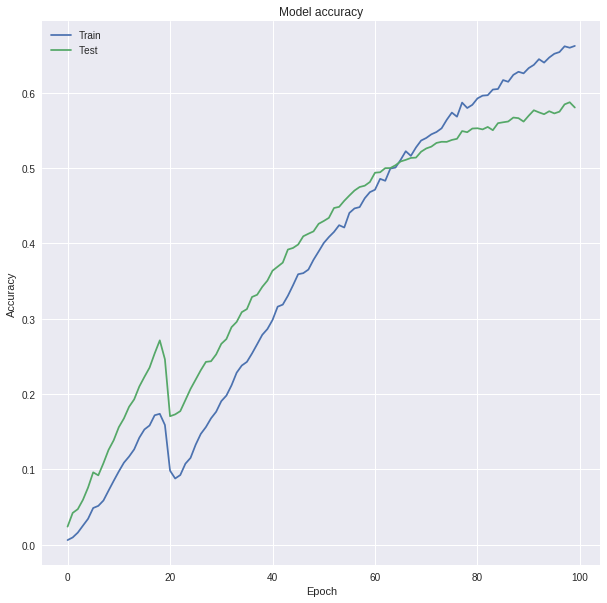

In [43]:
fig = plt.figure(figsize=(10,10))

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


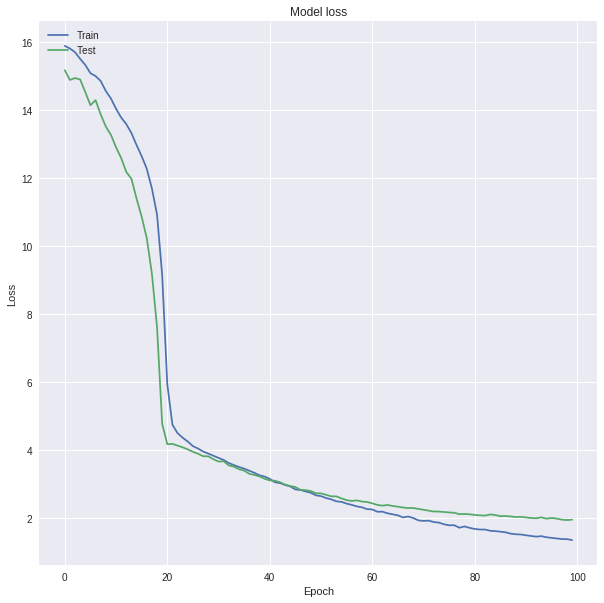

In [44]:
fig = plt.figure(figsize=(10,10))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()